In [16]:
import OffsetArrays
using Plots
using Revise
using ProgressMeter
using SparseArrays, LinearAlgebra, IndexedGraphs, Graphs
using IterTools
using DelimitedFiles


# Phase Space interaction-autoinfection

In [17]:
# S=0   I=1
# The times go from ti = 0 to ti=T+1
# when ti=0 it means that i is the zero patient
# when ti=T+1 it means that i is never infected

fr = 0.0
dil = 0.0
d = 3 # degree (fixed for now) 
T = 8 # discrete time

grid = 20
γvalues = LinRange(0.01,0.25,grid) # planted autoinfection probability
λvalues = γvalues # planted infection rate
folderstring = "./T=$(T)_d=$(d)_min=$(γvalues[1])_max=$(γvalues[end])_fr=$(fr)_dil=$(dil)/"

"./T=8_d=3_min=0.01_max=0.25_fr=0.0_dil=0.0/"

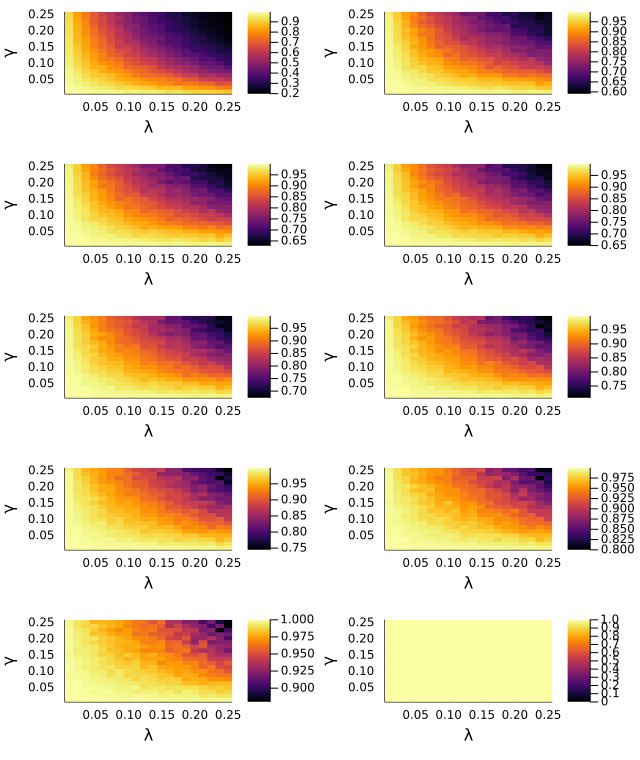

In [3]:
diag = readdlm("$(folderstring)diag.txt")
AUC = zeros(grid,grid,T+2)
for t = 2 : T + 2 
    AUC[:,:,t] .= readdlm("$(folderstring)AUC$(t - 1).txt") 
end

AUC[isnan.(AUC)] .= 1 ;
hdiag = heatmap(γvalues,λvalues,diag)
hAUC = Array{Plots.Plot{Plots.GRBackend}}(undef,T+1)

for t = 2 : T + 2 
    hAUC[t-1] = heatmap(γvalues,λvalues,AUC[:,:,t]) 
end

plot(hdiag, hAUC..., size=(640,760),layout = (5, 2),xlabel="λ",ylabel="γ")

#savefig("inference.pdf")

# Phase Space FalseRate - Dilution

In [ ]:
grid = 11
T = 8
d = 3
frRange = LinRange(0.0,0.5,grid) # planted autoinfection probability
dilRange = LinRange(0.0,1.0,grid) # planted infection rate

diag = readdlm("diag.txt")
AUC = zeros(grid,grid,T+2)
for t = 2 : T + 2 
    AUC[:,:,t] .= readdlm("AUC$(t - 1).txt") 
end

LoadError: DimensionMismatch("array could not be broadcast to match destination")

In [ ]:
AUC[isnan.(AUC)] .= 1 ;
hdiag = heatmap(frRange,dilRange,diag,title="Diagonal")
hAUC = Array{Plots.Plot{Plots.GRBackend}}(undef,T+1)

for t = 2 : T + 2 
    hAUC[t-1] = heatmap(frRange,dilRange,AUC[:,:,t],title="AUC(t=$(t-2))") 
end

plot(hdiag, hAUC..., size=(1500,820),layout = 10,ylabel="dilution",xlabel="false_rate",margin=5Plots.mm)

ErrorException: Length of x & y does not match the size of z.
Must be either `size(z) == (length(y), length(x))` (x & y define midpoints)
or `size(z) == (length(y)+1, length(x)+1))` (x & y define edges).

In [12]:
savefig("fr_dil2.pdf")

In [20]:
grid = 7
T = 8
d = 3
frRange = LinRange(0.0,0.5,grid) # planted autoinfection probability
dilRange = LinRange(1.0,1.0,1) # planted infection rate

diag = readdlm("diag.txt")

7×1 Matrix{Float64}:
 0.17949428244866378
 0.18720152967089027
 0.18244986211764253
 0.1905090892455034
 0.1852566956831341
 0.17849074866693837
 0.18651814259659297

In [31]:
AUC[:,:,1] 

1×7 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0